# The Sims-Flanagan high-fidelity trajectory leg

The Sims-Flanagan trajectory leg {cite:p}`sims` is implemented in `pykep` in the class {class}`pykep.leg.sims_flanagan_hf`. The leg can be used to describe a low-thrust leg with low-fidelity as it assumes Keplerian dynamics
and approximates the continuous thrust via a sequence of continuous, constant thrust arcs (zero-hold). The leg is defined by a starting position $\mathbf x_s = [\mathbf r_s, \mathbf v_s, m_s]$, an arrival position $\mathbf x_f = [\mathbf r_f, \mathbf v_f, m_f]$ and a time of flight $T$.

A sequence of throttles $\mathbf u = [u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, u_{x2}, u_{y2}, u_{z2}, ... ]$ define the direction and magnitude of the continuous throttle vector along each segment (i.e. trajectory parts of equal temporal length $\frac Tn$).

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.sims_flanagan_hf` efficiently.

We start with some imports:

In [1]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf


from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

We then define the spacecraft propulsion system and the initial and final state. In this case they are not related to any orbital mechanics and are chosen arbitrarily for the purpose of demostrating the API.

In [2]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.12
isp = 3000

# Initial state
ms = 1500.0
rs = np.array([1, 0.1, -0.1]) * pk.AU
vs = np.array([0.2, 1, -0.2]) * pk.EARTH_VELOCITY

# Final state
mf = 1300.0
rf = np.array([-1.2, -0.1, 0.1]) * pk.AU
vf = np.array([0.2, -1.023, 0.44]) * pk.EARTH_VELOCITY

# Throttles and tof
nseg = 10
cut = 0.6
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
tof = 324.0 * pk.DAY2SEC

Now we instantiate the leg:

In [3]:
# We are now ready to instantiate a leg
sf = pk.leg.sims_flanagan_hf(
    rvs=[rs, vs],
    ms=ms,
    throttles=throttles,
    rvf=[rf, vf],
    mf=mf,
    tof=tof,
    max_thrust=max_thrust,
    veff=isp * pk.G0,
    mu=mu,
    cut=cut,
)

And plot the trajectory represented by the random sequence of throttles.

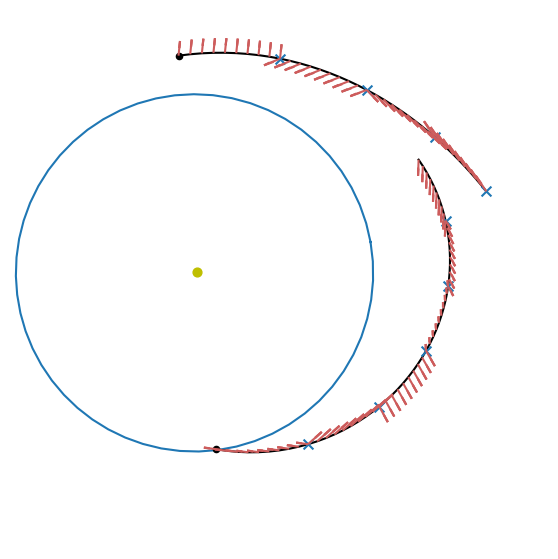

In [4]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize=(7, 7))

# Adding the Sun Earth and the boundary states
udpla = pk.udpla.jpl_lp(body="EARTH")
earth = pk.planet(udpla)
pk.plot.add_sun(ax, s=40)
pk.plot.add_planet_orbit(ax, earth)
ax.scatter(rs[0] / pk.AU, rs[1] / pk.AU, rs[2] / pk.AU, c="k", s=20)
ax.scatter(rf[0] / pk.AU, rf[1] / pk.AU, rf[2] / pk.AU, c="k", s=20)


# Plotting the trajctory leg
ax = pk.plot.add_sf_hf_leg(
    ax, sf, units=pk.AU, N=10, show_gridpoints=True, show_throttles=True, length=0.1, arrow_length_ratio=0.5
)


# Making the axis nicer
D=1
ax.set_xlim(-D,D)
ax.set_ylim(-D/2,D*3/2)
ax.view_init(90,0)
ax.axis('off');


# The gradients
The main function of this leg is to serve as a fwd-bck shooting blosk in larger optimization problems. The efficent autodiff computation of the gradients of the mismatch and throttle constraints are thus provided for convenience. Indicating the mismatch constraints with $\mathbf{mc}$ and the throttle constraints with $\mathbf{tc}$ we seek the following quntities:

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf x_s} \rightarrow (7\times7)
$$

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf x_f} \rightarrow (7\times7)
$$

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf {\tilde u}} \rightarrow (7\times(3\mathbf{nseg} + 1))
$$

$$
\frac{\partial \mathbf {tc}}{\partial \mathbf u} \rightarrow (\mathbf{nseg} \times3\mathbf{nseg})
$$

where $\mathbf x_s=[\mathbf r, \mathbf v, m]$ is the starting state, $\mathbf x_f$ is the final state $\mathbf u=[u_0, u_1 ... u_{nseg}]$ are the throttles and $\mathbf {\tilde u}=[\mathbf u, tof]$ the trottles augmented with $tof$ .

In [5]:
dmcdxs, dmcdxf, dmcdu = sf.compute_mc_grad()
print("dmcdxs shape: ", dmcdu.shape)
print("dmcdxf shape: ", dmcdu.shape)
print("dmcdu shape: ", dmcdu.shape)
dtcdu = sf.compute_tc_grad()
print("dtcdu shape: ", dtcdu.shape)

dmcdxs shape:  (7, 31)
dmcdxf shape:  (7, 31)
dmcdu shape:  (7, 31)
dtcdu shape:  (10, 30)


# Gradient correctness
We check the gradient correctness against numerical differentiation.

### First the mismatch constraints

In [6]:
# These functions are to be used in an estimate_gradient_h call
def mc_from_rvms(sf, rvms):
    sf.rvms = rvms
    return sf.compute_mismatch_constraints()

def mc_from_rvmf(sf, rvmf):
    sf.rvmf = rvmf
    return sf.compute_mismatch_constraints()

def mc_from_utilda(sf, utilda):
    sf.throttles = utilda[:-1]
    sf.tof = utilda[-1]
    return sf.compute_mismatch_constraints()

In [7]:
# Reference values where to compute the numerical gradients
rvms = sf.rvms.copy()
rvmf = sf.rvmf.copy()
utilda = sf.throttles.copy() + [sf.tof]
# Numerical gradients
dmcdxs_numerical = pg.estimate_gradient_h(lambda x: mc_from_rvms(sf, x), rvms, 1e-6).reshape(7,7)
dmcdxf_numerical = pg.estimate_gradient_h(lambda x: mc_from_rvmf(sf, x), rvmf, 1e-6).reshape(7,7)
dmcdu_numerical = pg.estimate_gradient_h(lambda x: mc_from_utilda(sf, x), utilda, 1e-6).reshape(7, nseg*3 + 1)

We check against the analytical gradients that all went well.

In [8]:
print("Check gradient of mc wrt xs: ", np.allclose(dmcdxs_numerical, dmcdxs, rtol=1e-5, atol=1e-5))  # True
print("Check gradient of mc wrt xf: ", np.allclose(dmcdxf_numerical, dmcdxf, rtol=1e-5, atol=1e-5))  # True
print("Check gradient of mc wrt u:  ", np.allclose(dmcdu_numerical, dmcdu, rtol=1e-3, atol=1e-3))  # True

Check gradient of mc wrt xs:  True
Check gradient of mc wrt xf:  True
Check gradient of mc wrt u:   True


### Then the throttle constraints

In [9]:
def tc_from_u(sf, u):
    sf.throttles = u
    return sf.compute_throttle_constraints()

In [10]:
# Reference values where to compute the numerical gradients
u = sf.throttles.copy()
# Numerical gradient
dtcdu_numerical = pg.estimate_gradient_h(lambda x: tc_from_u(sf, x), u, 1e-6).reshape(nseg, nseg*3)


In [11]:
print("Check gradient of tc wrt u:  ", np.allclose(dtcdu_numerical, dtcdu, rtol=1e-5, atol=1e-5))  # True

Check gradient of tc wrt u:   True


# Custom dynamics
We can also build a {class}`pykep.leg.sims_flanagan_hf` leg using a custom (zero-hold) dynamics to propagate the various segments. The dynamics needs to be written taking care of a number of things:

* It must have, as parameters, $\mu, v_{eff}, T_1, T_2, T_3$, where these last three values represent the Cartesian component of a zero-hold thrust in some reference frame.
* It needs to have 7 dimensions with the last variable being the mass.
* Its variational version must have the full state and $T_1, T_2, T_3$ as variational paramters.

In `pykep` all Taylor adaptive integrators that are called "zero_hold" respect such an interface and can thus be used.

Lets see how to use the CR3BP zero hold dynamics for this purpose.

In [12]:
# We create the zero-hold integrators
ta = pk.ta.get_zero_hold_cr3bp(1e-12)
ta_var = pk.ta.get_zero_hold_cr3bp_var(1e-6)
tas = [ta, ta_var]

# Data for starting and final orbit. In this case both periodic orbits around L2.
#Problem ID-0
#state_s = [ 1.0809931218390707,0.0, -0.20235953267405354,0.0, -0.19895001215078018,0.0, 1.]
#period_s = 2.353867041754664
#state_f = [ 1.1648780946517576,0.0,-0.11145303634437023,0.0,-0.20191923237095796,0.0, 1.]
#period_f = 3.3031221822879884

#Problem ID-1
state_s = [1.1648780946517576, 0.0, -0.11145303634437023, 0.0, -0.20191923237095796, 0.0, 1.]
period_s = 3.3031221822879884
state_f = [0.8241716997696729, 0.0, 0.05763660825010655, 0.0, 0.1681906215591753, 0.0, 1.]
period_f = 2.7629516051826917

mu_cr3bp = 0.01215058560962404
max_thrust = 0.3010999584011414 # already nd
veff = 11.56499372183432 # already nd

# We create new random throttles
throttles = np.random.uniform(-1, 1, size=(nseg * 3))

# For reference in the Earth-Moon system we use the units
LU = 384400000 #m
TU = 2360592. / 2 / np.pi #s
VU = LU/TU #m/s
MassU = 1000.
AccU = VU/TU #m/s^2
ForceU = AccU * MassU #kg m/s^2

In [13]:
# We are now ready to instantiate a generalized leg
sf = pk.leg.sims_flanagan_hf(
    rvms=state_s,
    throttles=throttles,
    rvmf=state_f,
    tof=3.141592653589793,
    max_thrust=max_thrust,
    veff=veff,
    mu=mu_cr3bp,
    cut=cut,
    tas=tas,
)

plotting is different as we are in the CR3BP!

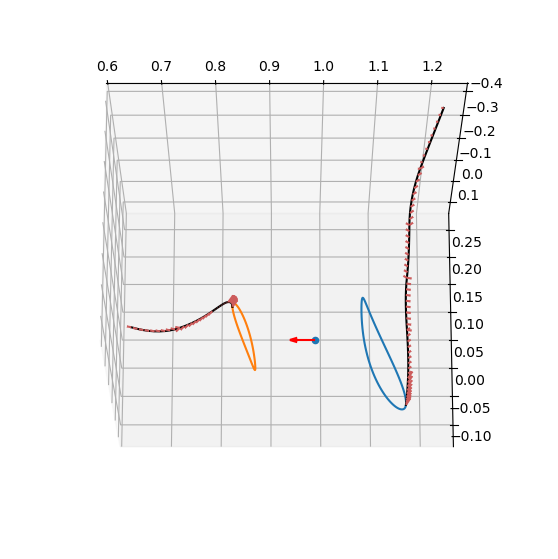

In [14]:
def plot_leg_cr3bp(sf, mu_cr3bp):
    # Making the axis
    ax = pk.plot.make_3Daxis(figsize=(7, 7))

    # Adding the Sun Earth and the boundary states
    #ax.scatter(-mu_cr3bp, 0, 0)
    ax.scatter(1-mu_cr3bp, 0, 0)

    # Adding an arrow to point towards the secondary
    # Coordinates of the arrow start point
    start = [1-mu_cr3bp, 0, 0]
    # Direction vector pointing towards the secondary
    direction = [-1, 0, 0]
    # Add the arrow to the 3D plot
    ax.quiver(start[0], start[1], start[2],
            direction[0], direction[1], direction[2],
            length=0.05, color='r', normalize=True)

    # Adding the starting and end orbits
    ta.pars[:] = [mu_cr3bp, 1., 0., 0., 0.]
    # START
    ta.time = 0
    ta.state[:] = state_s
    res = ta.propagate_grid(np.linspace(0, period_s, 100))[-1]
    ax.plot(res[:,0], res[:,1],res[:,2])
    #END
    ta.time = 0
    ta.state[:] = state_f
    res = ta.propagate_grid(np.linspace(0, period_f, 100))[-1]
    ax.plot(res[:,0], res[:,1],res[:,2])

    # Plotting the trajctory leg
    ax = pk.plot.add_sf_hf_leg(
        ax, sf, units=1., N=10, show_gridpoints=False, show_throttles=True, length=0.01, arrow_length_ratio=0.1,
    )

    # Making the axis nicer
    ax.view_init(-20,-90)

plot_leg_cr3bp(sf, mu_cr3bp)

# Embedding the leg into an optimization problem
We are now going to use the leg we instantiated above in an optimization problem (a pagmo UDP) looking for a sequence of throttles and a time of flight able to "close" the trajectory. Our decision vector will thus be:

$$
\mathbf x = [m_f, [u_x, u_y, u_z]\times n_{seg}, tof]
$$

We start by writing a minimal UPD (constructor, bounds fitness). Unfortunately we need quite some lines for this as to comply with pagmo UDP requirements, but the heart of it is rather simple. Its a leg and we optimize for tof and throttles as to close the mismatches.

In [15]:
class p2p_in_cr3bp:
    # The Constructor -----------------------------------------------------------------------------------
    def __init__(
        self,
        state_s,
        state_f,
        nseg,
        max_thrust,
        veff,
        mu,
        cut,
        mf_bounds=[0.5, 1.0],
        tof_bounds=[1.0, 5.0],
    ):
        # We create the zero-hold integrators
        ta = pk.ta.get_zero_hold_cr3bp(1e-12)
        ta_var = pk.ta.get_zero_hold_cr3bp_var(1e-6)
        tas = [ta, ta_var]
        # We store necessary data
        self.nseg = nseg
        self.mf_bounds = mf_bounds
        self.tof_bounds = tof_bounds
        # We instantiate the leg (tof, final mass and throttles will be changed when the leg is set from the decision vector,
        # hence they are just dummy values to construct the object)
        self.leg = pk.leg.sims_flanagan_hf(
            rvms=state_s,
            throttles=[0.0] * nseg * 3,
            rvmf=state_f,
            tof=2.0,
            max_thrust=max_thrust,
            veff=veff,
            mu=mu,
            cut=cut,
            tas=tas,
        )

    # The mandatory get_bounds UDP method ----------------------------------------------------------------
    def get_bounds(self):
        lb = [self.mf_bounds[0]] + [-1, -1, -1] * self.nseg + [self.tof_bounds[0]]
        ub = [self.mf_bounds[1]] + [1, 1, 1] * self.nseg + [self.tof_bounds[1]]
        return (lb, ub)

    def get_nec(self):
        return 7

    def get_nic(self):
        return self.nseg

    # Convenience method to set the leg from the decision vector
    def _set_leg_from_x(self, x):
        # x = [mf, throttles, tof]
        # We set the data in the leg using the decision vector
        self.leg.tof = x[-1]
        self.leg.mf = x[0]
        self.leg.throttles = x[1:-1]  # tof excluded

    # Fitness function -----------------------------------------------------------------------------------
    def fitness(self, x):
        # 1 - We set the leg using data in the decision vector
        self._set_leg_from_x(x)

        obj = -x[0]
        # 2 - We compute the constraints violations (mismatch+throttle)
        ceq = self.leg.compute_mismatch_constraints()
        cineq = self.leg.compute_throttle_constraints()
        retval = np.array([obj] + ceq + cineq)  # here we can sum lists
        return retval

    def plot(self, x):
        # Setting the leg
        self._set_leg_from_x(x)
        plot_leg_cr3bp(self.leg, mu_cr3bp)

We can now instatiate the UDP:

In [17]:
# Problem
udp = p2p_in_cr3bp(state_s, state_f, 20, max_thrust, veff, mu_cr3bp, cut = 0.6)
prob = pg.problem(udp)
prob.c_tol = 1e-8

# Algorithm
snopt72 = "/usr/local/lib/libsnopt7_c.so"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 1500)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-7)
algo = pg.algorithm(uda)

In [20]:
pop = pg.population(prob, 1)
pop = algo.evolve(pop)

Final mass:  0.990153035052


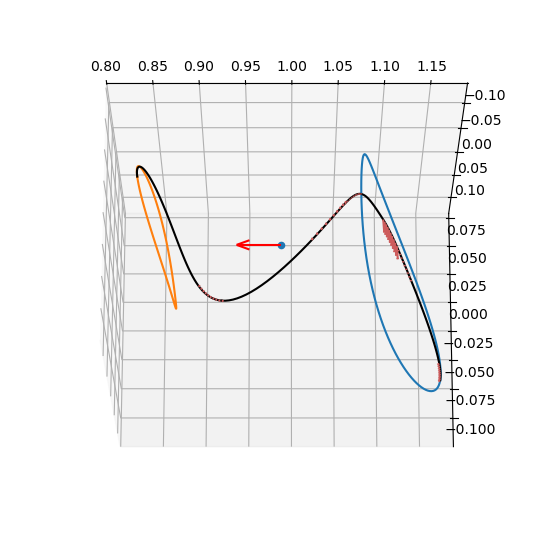

In [22]:
udp.plot(pop.champion_x)
print("Final mass: ", -pop.champion_f[0])

# Adding the gradients
The UDP we wrote above does not have any gradient information, as one can verify printing on screen the pagmo problem object. This means that solvers, when called to solve that problem, will not have access to the gradient and must compute it numerically if they need it (SQP methods such as SNOPT do ned it).

The {class}`pykep.leg.sims_flanagan_hf, as explained above, has the possibility to return various gradients which can be used to assemble the final gradients of the problem fitness. Lets see how




In [23]:
def _gradient(self, x):
    self._set_leg_from_x(x)
    _, mcg_xf, mcg_th_tof = self.leg.compute_mc_grad()
    tcg_th = self.leg.compute_tc_grad()

    # 1 - The gradient of the objective function (obj = -mf)
    retval = [-1.0]
    # 2 - The gradient of the mismatch contraints (mcg). We divide them in pos, vel mass as they have different scaling units
    # pos
    for i in range(7):
        # First w.r.t. mf
        retval.append(mcg_xf[i, -1])
        # Then the [throttles, tof]
        retval.extend(mcg_th_tof[i, :])
    # 3 -  The gradient of the throttle constraints
    for i in range(self.nseg):
        retval.extend(tcg_th[i, 3 * i : 3 * i + 3])
    return retval

def _gradient_sparsity(self):
    dim = 2 + 3 * self.nseg
    # The objective function only depends on the final mass, which is the first variable in the decision vector.
    retval = [[0, 0]]
    # The mismatch constraints depend on all variables.
    for i in range(1, 8):
        for j in range(dim):
            retval.append([i, j])
    # The throttle constraints only depend on the specific throttles (3).
    for i in range(self.nseg):
        retval.append([8 + i, 3 * i + 1])
        retval.append([8 + i, 3 * i + 2])
        retval.append([8 + i, 3 * i + 3])
    # We return the sparsity pattern
    return retval

#Monkey patch the class
p2p_in_cr3bp.gradient = _gradient
p2p_in_cr3bp.gradient_sparsity = _gradient_sparsity

In [24]:
# Problem
udp = p2p_in_cr3bp(state_s, state_f, 20, max_thrust, veff, mu_cr3bp, cut = 0.6)
prob = pg.problem(udp)
prob.c_tol = 1e-8

In [25]:
pop = pg.population(prob, 1)
pop = algo.evolve(pop)

Final mass:  0.990153308621


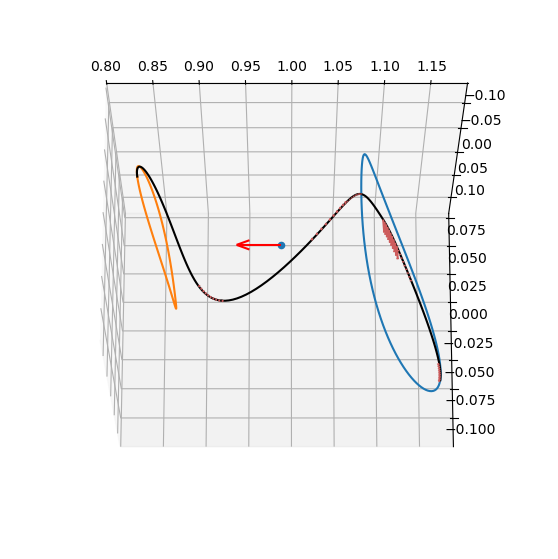

In [27]:
udp.plot(pop.champion_x)
print("Final mass: ", -pop.champion_f[0])